In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [3]:
df_ton = pd.read_csv("train_test_network.csv")

print("TON_IoT shape:", df_ton.shape)
df_ton.head()


TON_IoT shape: (211043, 44)


,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


In [13]:
df_ton_benign = df_ton[df_ton["label"] == 0].copy()

print("TON_IoT benign samples:", df_ton_benign.shape)


TON_IoT benign samples: (50000, 44)


In [4]:
import kagglehub

path = kagglehub.dataset_download("akashdogra/cic-iot-2023")
print("CIC dataset path:", path)

os.listdir(path)


CIC dataset path: C:\Users\dsatk\.cache\kagglehub\datasets\akashdogra\cic-iot-2023\versions\1


['part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00005-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00006-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00007-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00008-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00009-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00010-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00011-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00012-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00013-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00014-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00015-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',
 'part-00016-363d1ba3-8a

In [5]:
csv_path = os.path.join(path, os.listdir(path)[0])
df_cic = pd.read_csv(csv_path)

print("CIC raw shape:", df_cic.shape)
df_cic.head()


CIC raw shape: (238687, 47)


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1.0,0.0,1.0,...,0.000000,54.00,8.334383e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0.0,0.0,0.0,...,2.822973,57.04,8.292607e+07,9.5,10.464666,4.010353,160.987842,0.05,141.55,DoS-TCP_Flood
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.312799e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0.0,0.0,0.0,...,0.000000,50.00,8.301570e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0.0,1.0,0.0,...,23.113111,57.88,8.297300e+07,9.5,11.346876,32.716243,3016.808286,0.19,141.55,DoS-SYN_Flood


In [ ]:
df_cic["label"].value_counts() 

label
DDoS-ICMP_Flood            36554
DDoS-UDP_Flood             27626
DDoS-TCP_Flood             23149
DDoS-PSHACK_Flood          21210
DDoS-SYN_Flood             20739
DDoS-RSTFINFlood           20669
DDoS-SynonymousIP_Flood    18189
DoS-UDP_Flood              16957
DoS-TCP_Flood              13630
DoS-SYN_Flood              10275
BenignTraffic               5600
Mirai-greeth_flood          5016
Mirai-udpplain              4661
Mirai-greip_flood           3758
DDoS-ICMP_Fragmentation     2377
MITM-ArpSpoofing            1614
DDoS-ACK_Fragmentation      1505
DDoS-UDP_Fragmentation      1484
DNS_Spoofing                 925
Recon-HostDiscovery          697
Recon-OSScan                 517
Recon-PortScan               430
DoS-HTTP_Flood               414
VulnerabilityScan            210
DDoS-HTTP_Flood              169
DDoS-SlowLoris               106
DictionaryBruteForce          63
SqlInjection                  31
BrowserHijacking              30
CommandInjection              28
Back

In [8]:
df_cic_benign = df_cic[df_cic["label"] == "BenignTraffic"].copy()

print("CIC benign samples:", df_cic_benign.shape)


CIC benign samples: (5600, 47)


In [9]:
UNIFIED_FEATURES = [
    "flow_duration_log",
    "traffic_volume_log",
    "traffic_rate_log",
    "packet_count_log",
    "protocol_tcp",
    "protocol_udp",
    "protocol_http"
]


In [10]:
def project_ton_to_unified(df):
    df = df.copy()

    total_bytes = df["src_bytes"] + df["dst_bytes"]
    total_pkts  = df["src_pkts"] + df["dst_pkts"]

    df["flow_duration_log"] = np.log1p(df["duration"])
    df["traffic_volume_log"] = np.log1p(total_bytes)
    df["packet_count_log"] = np.log1p(total_pkts)
    df["traffic_rate_log"] = np.log1p(
        total_bytes / (df["duration"] + 1e-6)
    )

    df["protocol_tcp"] = (df["proto"].str.lower() == "tcp").astype(int)
    df["protocol_udp"] = (df["proto"].str.lower() == "udp").astype(int)
    df["protocol_http"] = df["proto"].str.lower().isin(["http", "https"]).astype(int)

    return df[UNIFIED_FEATURES]


In [11]:
def project_cic_to_unified(df):
    df = df.copy()

    df["flow_duration_log"] = np.log1p(df["Duration"])
    df["traffic_volume_log"] = np.log1p(df["Tot size"])
    df["packet_count_log"] = np.log1p(df["Number"])
    df["traffic_rate_log"] = np.log1p(df["Rate"])

    df["protocol_tcp"] = df["TCP"]
    df["protocol_udp"] = df["UDP"]
    df["protocol_http"] = ((df["HTTP"] == 1) | (df["HTTPS"] == 1)).astype(int)

    return df[UNIFIED_FEATURES]


In [14]:
X_ton_unified = project_ton_to_unified(df_ton_benign)
X_cic_unified = project_cic_to_unified(df_cic_benign)

print("TON unified shape:", X_ton_unified.shape)
print("CIC unified shape:", X_cic_unified.shape)


TON unified shape: (50000, 7)
CIC unified shape: (5600, 7)


In [15]:
X_global = pd.concat(
    [X_ton_unified, X_cic_unified],
    ignore_index=True
)

print("Global baseline shape:", X_global.shape)
X_global.head()


Global baseline shape: (55600, 7)


,flow_duration_log,traffic_volume_log,traffic_rate_log,packet_count_log,protocol_tcp,protocol_udp,protocol_http
0,0.000000,0.000000,0.000000,0.693147,0.0,1.0,0
1,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0
2,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0
3,0.000549,5.700444,13.202688,1.098612,0.0,1.0,0
4,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0


In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_global)


In [17]:
input_dim = X_scaled.shape[1]

inputs = Input(shape=(input_dim,))
x = Dense(64, activation="relu")(inputs)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
latent = Dense(16, activation="relu")(x)

x = Dense(32, activation="relu")(latent)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(input_dim)(x)

autoencoder = Model(inputs, outputs)
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,231 (24.34 KB)

 Trainable params: 6,231 (24.34 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=30,
    batch_size=128,
    validation_split=0.1,
    shuffle=True
)


Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1171 - val_loss: 1.6701
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0236 - val_loss: 1.3820
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 1.3298
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 1.2437
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0095 - val_loss: 1.0799
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.7041
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - val_loss: 0.3500
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060 - val_loss: 0.1538
Epoch 9/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_loss: 0.1272
Epoch 10/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - val_loss: 0.1324
Epoch 11/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0045 - val_loss: 0.2268
Epoch 12/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

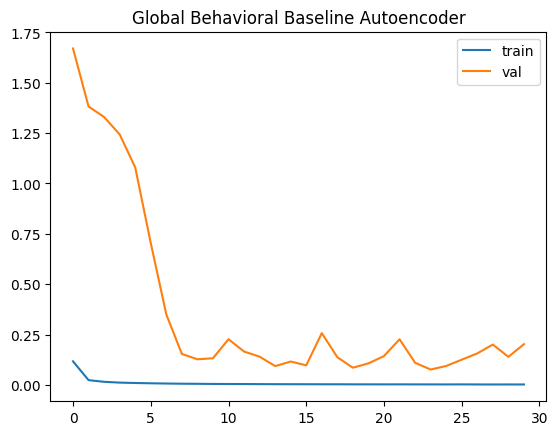

In [19]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.title("Global Behavioral Baseline Autoencoder")
plt.show()


In [20]:
X_eval = scaler.transform(project_ton_to_unified(df_ton))
X_pred = autoencoder.predict(X_eval)

reconstruction_error = np.mean(
    np.square(X_eval - X_pred),
    axis=1
)

anomaly_score = (
    reconstruction_error - reconstruction_error.min()
) / (
    reconstruction_error.max() - reconstruction_error.min()
)

df_ton["event_anomaly_score"] = anomaly_score


6596/6596 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


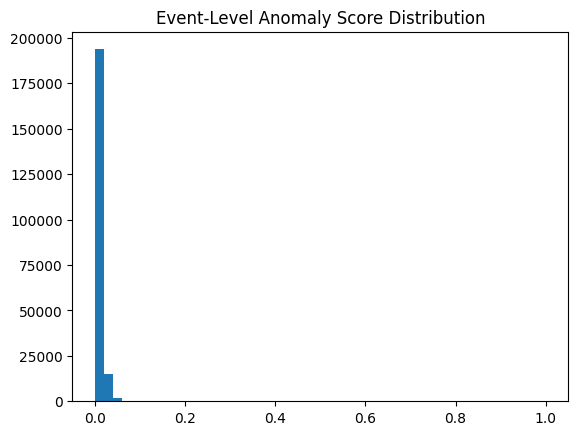

In [21]:
plt.hist(anomaly_score, bins=50)
plt.title("Event-Level Anomaly Score Distribution")
plt.show()


In [22]:
y_true = (df_ton["label"] != 0).astype(int)

if len(np.unique(y_true)) > 1:
    auc = roc_auc_score(y_true, anomaly_score)
    print("ROC-AUC:", auc)
else:
    print("ROC-AUC undefined (single class present)")


ROC-AUC: 0.3882546683183995


In [24]:
feature_errors = np.abs(X_eval - X_pred)

feature_contrib = pd.DataFrame(
    feature_errors,
    columns=UNIFIED_FEATURES
)

df_ton["top_anomalous_features"] = feature_contrib.apply(
    lambda r: r.nlargest(2).index.tolist(),
    axis=1
)
print(df_ton[["event_anomaly_score", "top_anomalous_features"]].head())

   event_anomaly_score                 top_anomalous_features
0             0.097911  [packet_count_log, flow_duration_log]
1             0.001944  [packet_count_log, flow_duration_log]
2             0.001944  [packet_count_log, flow_duration_log]
3             0.001944  [packet_count_log, flow_duration_log]
4             0.001944  [packet_count_log, flow_duration_log]


In [33]:
#drift analysis would go here
# Ensure temporal order for drift analysis
df_ton = df_ton.sort_values("duration").reset_index(drop=True)

df_ton[["duration", "event_anomaly_score"]].head()


,duration,event_anomaly_score
0,0.0,0.002394
1,0.0,0.002394
2,0.0,0.002394
3,0.0,0.002394
4,0.0,0.002603


In [34]:
WINDOW_SIZE = 1000

df_ton["rolling_anomaly_mean"] = (
    df_ton["event_anomaly_score"]
    .rolling(window=WINDOW_SIZE)
    .mean()
)

df_ton["rolling_anomaly_std"] = (
    df_ton["event_anomaly_score"]
    .rolling(window=WINDOW_SIZE)
    .std()
)

df_ton[["event_anomaly_score", "rolling_anomaly_mean"]].tail()


,event_anomaly_score,rolling_anomaly_mean
211038,0.330814,0.106490
211039,0.330967,0.106776
211040,0.329843,0.107062
211041,0.330233,0.107354
211042,0.372240,0.107677


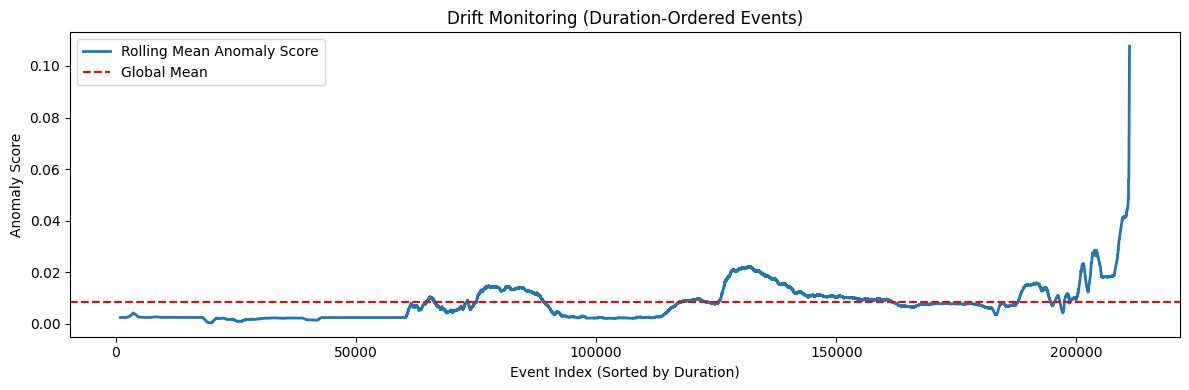

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(
    df_ton["rolling_anomaly_mean"],
    label="Rolling Mean Anomaly Score",
    linewidth=2
)

plt.axhline(
    df_ton["event_anomaly_score"].mean(),
    color="red",
    linestyle="--",
    label="Global Mean"
)

plt.title("Drift Monitoring (Duration-Ordered Events)")
plt.xlabel("Event Index (Sorted by Duration)")
plt.ylabel("Anomaly Score")
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
GLOBAL_MEAN = df_ton["event_anomaly_score"].mean()
DRIFT_THRESHOLD = GLOBAL_MEAN * 1.5

latest_mean = df_ton["rolling_anomaly_mean"].iloc[-1]

print("Global mean anomaly score:", round(GLOBAL_MEAN, 4))
print("Latest rolling mean:", round(latest_mean, 4))
print("Drift threshold:", round(DRIFT_THRESHOLD, 4))

if latest_mean > DRIFT_THRESHOLD:
    print(" DRIFT DETECTED — baseline behavior shifted")
else:
    print(" No significant drift detected")


Global mean anomaly score: 0.0083
Latest rolling mean: 0.1077
Drift threshold: 0.0124
 DRIFT DETECTED — baseline behavior shifted


In [ ]:
# Drift Flags (For Audit / Governance
df_ton["drift_flag"] = (
    df_ton["rolling_anomaly_mean"] > DRIFT_THRESHOLD
)

df_ton["drift_flag"].value_counts()


drift_flag
False    169430
True      41613
Name: count, dtype: int64

In [39]:
drift_policy = {
    "time_proxy": "flow duration ordering",
    "monitoring_window": WINDOW_SIZE,
    "drift_threshold": "1.5 × global anomaly mean",
    "detection_type": "gradual drift",
    "action_on_drift": "retrain baseline using recent benign data",
    "automation_level": "human-in-the-loop",
    "review_frequency": "30 days"
}

drift_policy


{'time_proxy': 'flow duration ordering',
 'monitoring_window': 1000,
 'drift_threshold': '1.5 × global anomaly mean',
 'detection_type': 'gradual drift',
 'action_on_drift': 'retrain baseline using recent benign data',
 'automation_level': 'human-in-the-loop',
 'review_frequency': '30 days'}

In [40]:
df_ton.to_csv(
    "toniot_event_scores_with_drift.csv",
    index=False
)

print(" Drift-aware file saved successfully")


 Drift-aware file saved successfully


In [28]:
df_ton.to_csv(
    "toniot_event_scores_global_baseline.csv",
    index=False
)

baseline_metadata = {
    "baseline_id": "ae_global_v2",
    "datasets": ["TON_IoT", "CIC-IoT-2023"],
    "features": UNIFIED_FEATURES,
    "training_type": "benign_only",
    "epochs": 30
}

baseline_metadata

{'baseline_id': 'ae_global_v2',
 'datasets': ['TON_IoT', 'CIC-IoT-2023'],
 'features': ['flow_duration_log',
  'traffic_volume_log',
  'traffic_rate_log',
  'packet_count_log',
  'protocol_tcp',
  'protocol_udp',
  'protocol_http'],
 'training_type': 'benign_only',
 'epochs': 30}

In [29]:
from datetime import datetime

BASELINE_ID = "ae_global_v2"

baseline_metadata = {
    "baseline_id": BASELINE_ID,
    "baseline_type": "global",
    "model_type": "deep_autoencoder",
    "training_type": "unsupervised_benign_only",
    "datasets": ["TON_IoT", "CIC-IoT-2023"],
    "features": UNIFIED_FEATURES,
    "epochs": 30,
    "created_at": datetime.now().isoformat()
}

baseline_metadata


{'baseline_id': 'ae_global_v2',
 'baseline_type': 'global',
 'model_type': 'deep_autoencoder',
 'training_type': 'unsupervised_benign_only',
 'datasets': ['TON_IoT', 'CIC-IoT-2023'],
 'features': ['flow_duration_log',
  'traffic_volume_log',
  'traffic_rate_log',
  'packet_count_log',
  'protocol_tcp',
  'protocol_udp',
  'protocol_http'],
 'epochs': 30,
 'created_at': '2026-02-06T23:25:58.136562'}

In [30]:
import json
from pathlib import Path

BASELINE_ID = "ae_global_v2"

# Absolute-safe paths
BASE_DIR = Path.cwd().parent
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = MODEL_DIR / f"{BASELINE_ID}.keras"
META_PATH  = MODEL_DIR / f"{BASELINE_ID}_meta.json"

# Save model (correct extension)
autoencoder.save(MODEL_PATH)

# Save metadata
with open(META_PATH, "w") as f:
    json.dump(baseline_metadata, f, indent=4)

print("Model saved at:", MODEL_PATH)
print("Metadata saved at:", META_PATH)



Model saved at: c:\Users\dsatk\Downloads\pbl\models\ae_global_v2.keras
Metadata saved at: c:\Users\dsatk\Downloads\pbl\models\ae_global_v2_meta.json


In [31]:
df_ton["baseline_id"] = BASELINE_ID

df_ton.to_csv(
    "toniot_event_scores_global_baseline_v2.csv",
    index=False
)

print("Baseline ID attached to all detections.")


Baseline ID attached to all detections.
